In [1]:
pip install opencv-python matplotlib numpy scipy scikit-image scikit-learn pandas seaborn tensorflow keras h5py 

Defaulting to user installation because normal site-packages is not writeable
ERROR: Ignored the following versions that require a different python version: 1.10.0 Requires-Python <3.12,>=3.8; 1.10.0rc1 Requires-Python <3.12,>=3.8; 1.10.0rc2 Requires-Python <3.12,>=3.8; 1.10.1 Requires-Python <3.12,>=3.8; 1.11.0 Requires-Python <3.13,>=3.9; 1.11.0rc1 Requires-Python <3.13,>=3.9; 1.11.0rc2 Requires-Python <3.13,>=3.9; 1.11.1 Requires-Python <3.13,>=3.9; 1.11.2 Requires-Python <3.13,>=3.9; 1.11.3 Requires-Python <3.13,>=3.9; 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10; 1.7.2 Requires-Python >=3.7,<3.11; 1.7.3 Requires-Python >=3.7,<3.11; 1.8.0 Requires-Python >=3.8,<3.11; 1.8.0rc1 Requires-Python >=3.8,<3.11; 1.8.0rc2 Requires-Python >=3.8,<3.11; 1.8.0rc3 Requires-Python >=3.8,<3.11; 1.8.0rc4 Requires-Python >=3.8,<3.11; 1.8.1 Requires-Python >=3.8,<3.11; 1.9.0 Requires-Python >=3.8,<3.12; 1.9.

outline image saved as exractimage.png


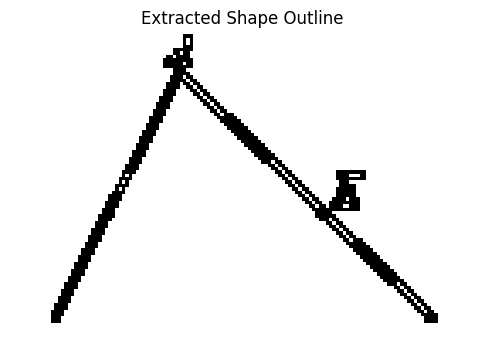

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def manual_threshold(image, threshold=128):
    """Apply manual thresholding without OpenCV functions."""
    height, width = image.shape
    binary = np.zeros((height, width), dtype=np.uint8)
    for i in range(height):
        for j in range(width):
            if image[i, j] < threshold:
                binary[i, j] = 255  # Foreground (Shape)
            else:
                binary[i, j] = 0  # Background
    return binary

def sobel_edge_detection(image):
    """Manually compute Sobel edge detection."""
    height, width = image.shape
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])  # X-direction
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])  # Y-direction

    edge_image = np.zeros((height, width), dtype=np.uint8)

    # Apply Sobel filter manually
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            gx = np.sum(image[i - 1:i + 2, j - 1:j + 2] * sobel_x)
            gy = np.sum(image[i - 1:i + 2, j - 1:j + 2] * sobel_y)
            edge_magnitude = np.sqrt(gx**2 + gy**2)

            if edge_magnitude > 100:  # Edge threshold
                edge_image[i, j] = 255  # Edge detected

    return edge_image

def find_largest_contour(binary):
    """Find and return the largest contour from a binary image."""
    height, width = binary.shape
    visited = np.zeros((height, width), dtype=bool)
    contours = []

    def edge_follow(x, y):
        """Follow the contour edges."""
        stack = [(x, y)]
        contour = []
        while stack:
            cx, cy = stack.pop()
            if 0 <= cx < height and 0 <= cy < width and not visited[cx, cy] and binary[cx, cy] == 255:
                visited[cx, cy] = True
                contour.append((cx, cy))
                stack.extend([(cx-1, cy), (cx+1, cy), (cx, cy-1), (cx, cy+1)])
        return contour

    for i in range(height):
        for j in range(width):
            if binary[i, j] == 255 and not visited[i, j]:
                contour = edge_follow(i, j)
                if len(contour) > 200:  # Remove small contours (text)
                    contours.append(contour)

    if contours:
        return max(contours, key=len)  # Largest contour
    return None

def extract_shape_outline(image_path):
    """Extract only the shape outline while removing text."""
    # Load grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Error: Image not found")
        return

    # Invert image (so shapes become dark on a light background)
    image = 255 - image

    # Apply manual thresholding
    binary = manual_threshold(image, threshold=150)

    # Apply Sobel edge detection
    edges = sobel_edge_detection(binary)

    # Find largest contour
    largest_contour = find_largest_contour(edges)
    if largest_contour is None:
        print("No valid contour found")
        return

    # Create a blank image with white background
    outline_image = np.ones_like(image) * 255  # White background

    # Draw the largest contour as black outline
    for x, y in largest_contour:
        outline_image[x, y] = 0  # Black outline

    outlineImagePath = "exractimage.png"
    cv2.imwrite(outlineImagePath, outline_image)
    print(f"outline image saved as {outlineImagePath}")

    # Display the extracted shape outline
    plt.figure(figsize=(6, 6))
    plt.imshow(outline_image, cmap='gray')
    plt.title("Extracted Shape Outline")
    plt.axis("off")
    plt.show()

# Example usage
image_path = "/home/ashwathama/Documents/GitHub/2dshapedetection-major/TEST/0.png"
extract_shape_outline(image_path)


Outline image saved as extracted_outline.png


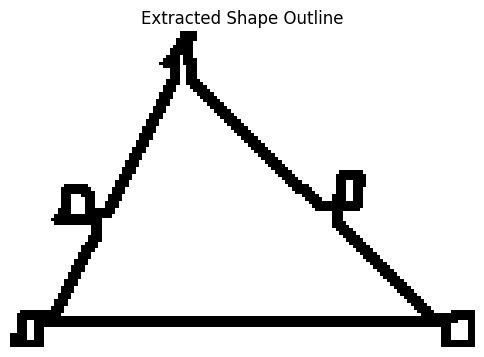

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_shape_outline(image_path, output_path="extracted_outline.png"):
    """Extract only the shape outline while removing inner details."""

    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Error: Image not found")
        return

    # Apply adaptive thresholding to segment the shape
    binary = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    # Use morphological operations to remove noise
    kernel = np.ones((3,3), np.uint8)
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Find contours
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a blank white image for the outline
    outline_image = np.ones_like(image) * 255

    # Draw the largest contour (assumed to be the main shape outline)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        cv2.drawContours(outline_image, [largest_contour], -1, (0, 0, 0), 2)

    # Save the output image
    cv2.imwrite(output_path, outline_image)
    print(f"Outline image saved as {output_path}")

    # Display the extracted shape outline
    plt.figure(figsize=(6, 6))
    plt.imshow(outline_image, cmap='gray')
    plt.title("Extracted Shape Outline")
    plt.axis("off")
    plt.show()

# Example usage
image_path = "/home/ashwathama/Documents/GitHub/2dshapedetection-major/TEST/0.png"
extract_shape_outline(image_path)


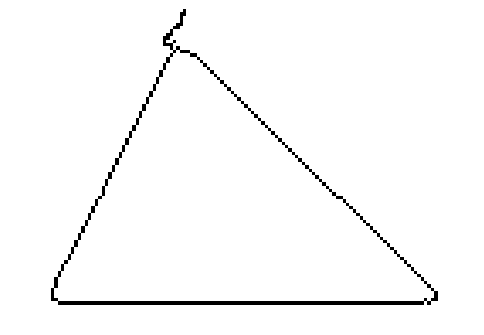

error: OpenCV(4.11.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:836: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'


In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "/home/ashwathama/Documents/GitHub/2dshapedetection-major/TEST/0.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if image is loaded successfully
if image is None:
    print(f"Error: Unable to load image from {image_path}")
    exit()

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Use Canny edge detection
edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter out small contours to remove text
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 500]

# Create an empty mask with white background
contour_mask = np.ones_like(image) * 255
cv2.drawContours(contour_mask, filtered_contours, -1, (0), thickness=1)

# Display the extracted outline
plt.figure(figsize=(6, 6))
plt.imshow(contour_mask, cmap='gray')
plt.axis('off')
plt.show()

# Save the result
output_path = "/home/ashwathama/Documents/GitHub/2dshapedetection-major"
cv2.imwrite(output_path, contour_mask)
print(f"Filtered outline saved at: {output_path}")


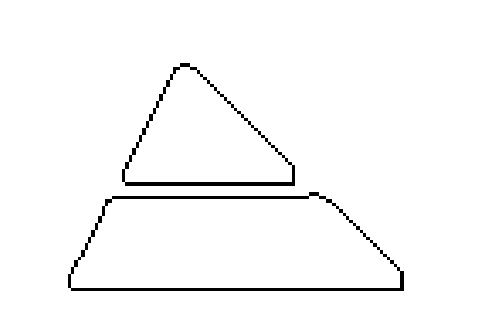

error: OpenCV(4.11.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:836: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'


In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "/home/ashwathama/Documents/GitHub/2dshapedetection-major/TEST/0.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if image is loaded successfully
if image is None:
    print(f"Error: Unable to load image from {image_path}")
    exit()

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Use adaptive thresholding to handle varying lighting conditions
adaptive_thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                        cv2.THRESH_BINARY_INV, 11, 2)

# Perform morphological operations to remove small noise
kernel = np.ones((3, 3), np.uint8)
processed = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

# Use Canny edge detection
edges = cv2.Canny(processed, threshold1=50, threshold2=150)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter out small contours to remove text
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 800]

# Create an empty mask with white background
contour_mask = np.ones_like(image) * 255
cv2.drawContours(contour_mask, filtered_contours, -1, (0), thickness=1)

# Display the extracted outline
plt.figure(figsize=(6, 6))
plt.imshow(contour_mask, cmap='gray')
plt.axis('off')
plt.show()

# Save the result
output_path = "/home/ashwathama/Documents/GitHub/2dshapedetection-major"
cv2.imwrite(output_path, contour_mask)
print(f"Filtered outline saved at: {output_path}")

In [1]:
import cv2
import numpy as np
im = cv2.imread(r'C:\Users\ashut\Documents\GitHub\2dshapedetection-major\TEST\48.png')

print(type(im))
# <class 'numpy.ndarray'>

print(im.shape)

<class 'numpy.ndarray'>
(129, 129, 3)


In [2]:

#sharpening and binarization then morphological oprning operation

#image = cv2.imread(r'C:\Users\ashut\Documents\GitHub\2dshapedetection-major\TEST\48.png')
##image = cv2.imread(r'C:\Users\ashut\Documents\GitHub\2dshapedetection-major\TEST\13.png')
image = cv2.imread(r'C:\Users\ashut\Documents\GitHub\2dshapedetection-major\TEST\2.png')
new_size = (512, 512)  
resizedImage = cv2.resize(image, new_size, interpolation=cv2.INTER_CUBIC)


gray = cv2.cvtColor(resizedImage, cv2.COLOR_BGR2GRAY)

# shaprpening = np.array([[0, -1, 0], 
#                         [-1, 5, -1], 
#                         [0, -1, 0]])

sharpening = np.array([[ -1, -1, -1],         #strong sharpening
                              [ -1,  9, -1], 
                              [ -1, -1, -1]])

# sharpening = np.array([[ 1,  1,  1],          #soft 
#                             [ 1, -7,  1], 
#                             [ 1,  1,  1]])

# sharpening = np.array([[  0,  1,  0],     #laplacian
#                       [  1, -4,  1], 
#                       [  0,  1,  0]])

sharpened = cv2.filter2D(gray, -1, sharpening)
_, binary = cv2.threshold(sharpened, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) #otsu


#kernel = np.ones((3,3), np.uint8)
kernel = np.ones((3,3), np.uint8)  # Square kernel
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))  # Rectangular kernel
# kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))  # Cross-shaped kernel
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))  # Larger elliptical kernel

# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)



# Display results
cv2.imshow('Sharpened', sharpened)
cv2.imshow('Binary', binary)
cv2.imshow('Morphological Opening', opened)

cv2.waitKey(0)
cv2.destroyAllWindows()


In [3]:
image = cv2.imread(r'C:\Users\ashut\Documents\GitHub\2dshapedetection-major\TEST\2.png')
new_size = (512, 512)  
resizedImage = cv2.resize(image, new_size, interpolation=cv2.INTER_CUBIC)

# Convert to grayscale
gray = cv2.cvtColor(resizedImage, cv2.COLOR_BGR2GRAY)

# Sharpening filters
# shaprpening = np.array([[0, -1, 0], 
#                         [-1, 5, -1], 
#                         [0, -1, 0]])

sharpening = np.array([[-1, -1, -1],  # strong sharpening
                       [-1,  9, -1], 
                       [-1, -1, -1]])

# sharpening = np.array([[ 1,  1,  1],          #soft 
#                             [ 1, -7,  1], 
#                             [ 1,  1,  1]])

# sharpening = np.array([[  0,  1,  0],     #laplacian
#                       [  1, -4,  1], 
#                       [  0,  1,  0]])

sharpened = cv2.filter2D(gray, -1, sharpening)

# Apply binarization using Otsu's thresholding
_, binary = cv2.threshold(sharpened, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Morphological opening operation
# kernel = np.ones((3,3), np.uint8)
kernel = np.ones((3,3), np.uint8)  # Square kernel
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))  # Rectangular kernel
# kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))  # Cross-shaped kernel
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))  # Larger elliptical kernel

# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))

# Ensure proper iterations for morphological operation
opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

# Display results
cv2.imshow('Sharpened', sharpened)
cv2.imshow('Binary', binary)
cv2.imshow('Morphological Opening', opened)

cv2.waitKey(0)
cv2.destroyAllWindows()


In [5]:

image = cv2.imread(r'C:\Users\ashut\Documents\GitHub\2dshapedetection-major\TEST\2.png')
new_size = (512, 512)  
resizedImage = cv2.resize(image, new_size, interpolation=cv2.INTER_CUBIC)

# Convert to grayscale
gray = cv2.cvtColor(resizedImage, cv2.COLOR_BGR2GRAY)

# Sharpening filters
# shaprpening = np.array([[0, -1, 0], 
#                         [-1, 5, -1], 
#                         [0, -1, 0]])

sharpening = np.array([[-1, -1, -1],  # strong sharpening
                       [-1,  9, -1], 
                       [-1, -1, -1]])

# sharpening = np.array([[ 1,  1,  1],          #soft 
#                             [ 1, -7,  1], 
#                             [ 1,  1,  1]])

# sharpening = np.array([[  0,  1,  0],     #laplacian
#                       [  1, -4,  1], 
#                       [  0,  1,  0]])

sharpened = cv2.filter2D(gray, -1, sharpening)

# Apply binarization using Otsu's thresholding
_, binary = cv2.threshold(sharpened, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Morphological opening operation
# kernel = np.ones((3,3), np.uint8)
kernel = np.ones((3,3), np.uint8)  # Square kernel
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))  # Rectangular kernel
# kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))  # Cross-shaped kernel
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))  # Larger elliptical kernel

# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))

# Ensure proper iterations for morphological operation
opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

# ----- Connected Component Analysis to remove small dots -----
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(opened, 8, cv2.CV_32S)

min_size = 100  # Remove components smaller than this size
for i in range(1, num_labels):  # Ignore background label 0
    if stats[i, cv2.CC_STAT_AREA] < min_size:
        opened[labels == i] = 0  # Remove small components

# Display results
cv2.imshow('Sharpened', sharpened)
cv2.imshow('Binary', binary)
cv2.imshow('Morphological Opening (Filtered)', opened)

cv2.waitKey(0)
cv2.destroyAllWindows()


In [3]:
import cv2

# Load the image
img_path = r"C:\Users\ashut\Desktop\ElementaryCQT_LOWRES\Circle\Circle_Chord\circ_chr_0.png"
img = cv2.imread(img_path)

# Check if the image is loaded correctly
if img is None:
    print("Error: Image not loaded. Check the file path.")
else:
    print("Image Shape:", img.shape)  # (height, width, channels)


Image Shape: (120, 120, 3)
